# Consistency with "lifted" control

In [24]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl

import hydrogym.firedrake as hgym
from step_response import control_vec, LinearBDFSolver

output_dir = "../eig_output"
output_dir = "../re40_med_eig_output"
# output_dir = "../re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

In [25]:
flow = hgym.RotaryCylinder(
    Re=40,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


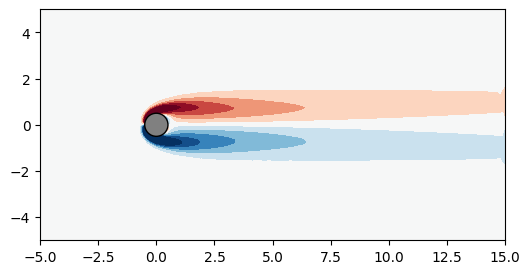

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

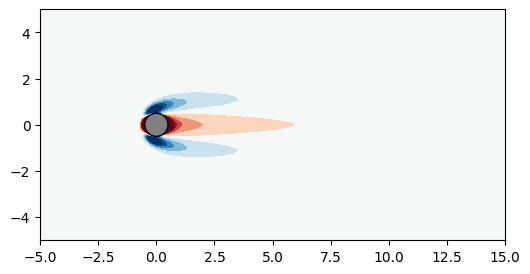

In [27]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

### Lifted control

In [28]:
dt = 0.01
tf = 10.0
n_steps = int(tf // dt)

def pulse(t):
    if (t > 0.2) and (t < 1.2):
        return 1
    return 0

In [29]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.Function(fn_space)  # Zero initial condition

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

CL_lift = np.zeros(n_steps)
CD_lift = np.zeros(n_steps)

flow.q.assign(solver.q)
for i in range(n_steps):
    c.assign(pulse(i * dt))

    q = solver.step()
    flow.q.assign(q)
    CL_lift[i], CD_lift[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_lift[i]:.4f}, CD={CD_lift[i]:.4f}")
        print(f"   u={c}")

t=0.00, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.01, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.02, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.03, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.04, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.05, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.06, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.07, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.08, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.09, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.10, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.11, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.12, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.13, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.14, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.15, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.16, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.17, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.18, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.19, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.20, CL=0.0000, CD=0.0000
   u=[0.+0.j]
t=0.21, CL=0.0053, CD=-0.0000
   u=[1.+0.j]
t=0.22, CL=0.0125, CD=-0.0000
   u=[1.+0.j]
t=0.23, C

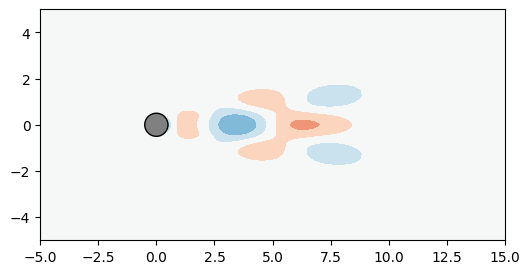

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

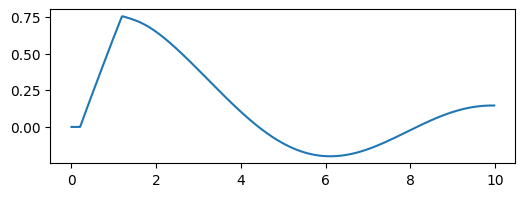

In [31]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, CL_lift)
plt.show()

### BC function control

In [32]:
# Feedthrough term
flow.q.assign(qC)
D, _ = map(np.real, flow.get_observations())
print(D)

-0.2423385745330402


In [36]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.Function(fn_space)  # Zero initial condition

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

CL_bc = np.zeros(n_steps)
CD_bc = np.zeros(n_steps)
y = np.zeros(n_steps)

# Integrated control signal (this is the BC value)
rho = 0.0

for i in range(n_steps):
    rho = rho - dt * pulse(i * dt)
    flow.bcu_actuation[0].set_scale(rho)

    q = solver.step()
    flow.q.assign(q)
    CL_bc[i], CD_bc[i] = map(np.real, flow.get_observations())

    # The full flow field with BCs is q = qH + qC * rho, where qH is the solution
    # to the homogeneous problem with forcing.  Then the expected observation
    # is y = C @ qH = C @ (q - qC * rho) = C @ q - D * rho, since D = C @ qC.
    y[i] = CL_bc[i] - D * rho

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_bc[i]:.4f}, CD={CD_bc[i]:.4f}")
        print(f"   u={c}, y={y[i]}")

qf = flow.q.copy(deepcopy=True)


t=0.00, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.01, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.02, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.03, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.04, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.05, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.06, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.07, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.08, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.09, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.10, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.11, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.12, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.13, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.14, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.15, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.16, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.17, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.18, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0
t=0.19, CL=0.0000, CD=0.0000
   u=[0.+0.j], y=0.0


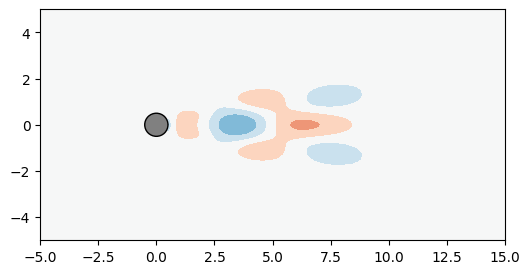

In [37]:
flow.q.assign(qf + qC)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

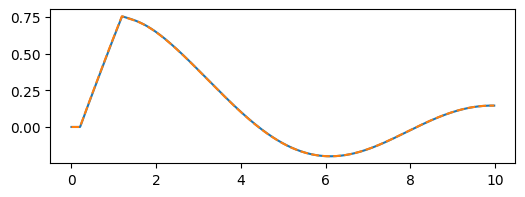

In [40]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, CL_lift)
ax.plot(t, y, '--')
plt.show()